In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, f_classif
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# EDA (Data cleansing and preparation, Insightful visuals)

In [44]:
app_data = pd.read_csv('/kaggle/input/loan-defaulter/application_data.csv')
col_des =pd.read_csv('/kaggle/input/loan-defaulter/columns_description.csv')
pre_app =pd.read_csv('/kaggle/input/loan-defaulter/previous_application.csv')

In [45]:
# Inspecting missing values in app_data and pre_app
print(app_data.isnull().sum())
print(pre_app.isnull().sum())

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1

In [46]:
# Dropping columns with more than 50% missing values
columns_to_drop = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
                   'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']
pre_app.drop(columns=columns_to_drop, inplace=True)

In [47]:
# Fill remaining numerical columns with median
numerical_cols_pre = pre_app.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols_pre:
    if pre_app[col].isnull().sum() > 0:
        pre_app[col] = pre_app[col].fillna(pre_app[col].median())

# Fill remaining categorical columns with mode
categorical_cols_pre = pre_app.select_dtypes(include=['object']).columns
for col in categorical_cols_pre:
    if pre_app[col].isnull().sum() > 0:
        pre_app[col] = pre_app[col].fillna(pre_app[col].mode()[0])


In [48]:
# Inspecting missing values in app_data and pre_app
print(app_data.isnull().sum())
print(pre_app.isnull().sum())

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
SK_ID_PREV                     0
SK_ID_CURR                     0
NAME_CONTRACT_TYPE             0
AMT_ANNUITY                    0
AMT_APPLICATION                0
AMT_CREDIT                     0
AMT_DOWN_PAYMENT               0
AMT_GOODS_PRICE                0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
FLAG_LAST_APPL_PER_CONTRACT    0
NFLAG_LAST_APPL_IN_DAY         0
RATE_DOWN_PAYMENT              0
RATE_INTEREST_PRIMARY          0
RATE_INTEREST_PRIVILEGED       0
NAME_CASH_LOAN_PURPOSE         0
NAME_CONTRACT_STATUS           0
DAYS_DECISION    

In [49]:
# Checking for duplicates in app_data
num_duplicates_app_data = app_data.duplicated().sum()
print(f"Number of duplicate rows in app_data: {num_duplicates_app_data}")

# Checking for duplicates in pre_app
num_duplicates_pre_app = pre_app.duplicated().sum()
print(f"Number of duplicate rows in pre_app: {num_duplicates_pre_app}")

Number of duplicate rows in app_data: 0
Number of duplicate rows in pre_app: 0


In [50]:
# Removing outliers using the IQR method for AMT_INCOME_TOTAL in app_data
Q1 = app_data['AMT_INCOME_TOTAL'].quantile(0.25)
Q3 = app_data['AMT_INCOME_TOTAL'].quantile(0.75)
IQR = Q3 - Q1

# Filtering rows within the acceptable range
app_data = app_data[(app_data['AMT_INCOME_TOTAL'] >= (Q1 - 1.5 * IQR)) & 
                    (app_data['AMT_INCOME_TOTAL'] <= (Q3 + 1.5 * IQR))]

In [51]:
# Summary statistics for app_data and pre_app
print("Summary statistics for application data:")
print(app_data.describe())

print("\nSummary statistics for previous application data:")
print(pre_app.describe())


Summary statistics for application data:
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  293476.000000  293476.000000  293476.000000     293476.000000   
mean   278188.094710       0.081809       0.414139     154263.935956   
std    102782.717187       0.274074       0.720161      64014.949755   
min    100002.000000       0.000000       0.000000      25650.000000   
25%    189137.750000       0.000000       0.000000     112500.000000   
50%    278229.500000       0.000000       0.000000     135000.000000   
75%    367074.500000       0.000000       1.000000     202500.000000   
max    456255.000000       1.000000      19.000000     337500.000000   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  2.934760e+05  293464.000000     2.932040e+05   
mean   5.797509e+05   26254.699461     5.200857e+05   
std    3.844930e+05   13420.472584     3.513777e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16231.500000 

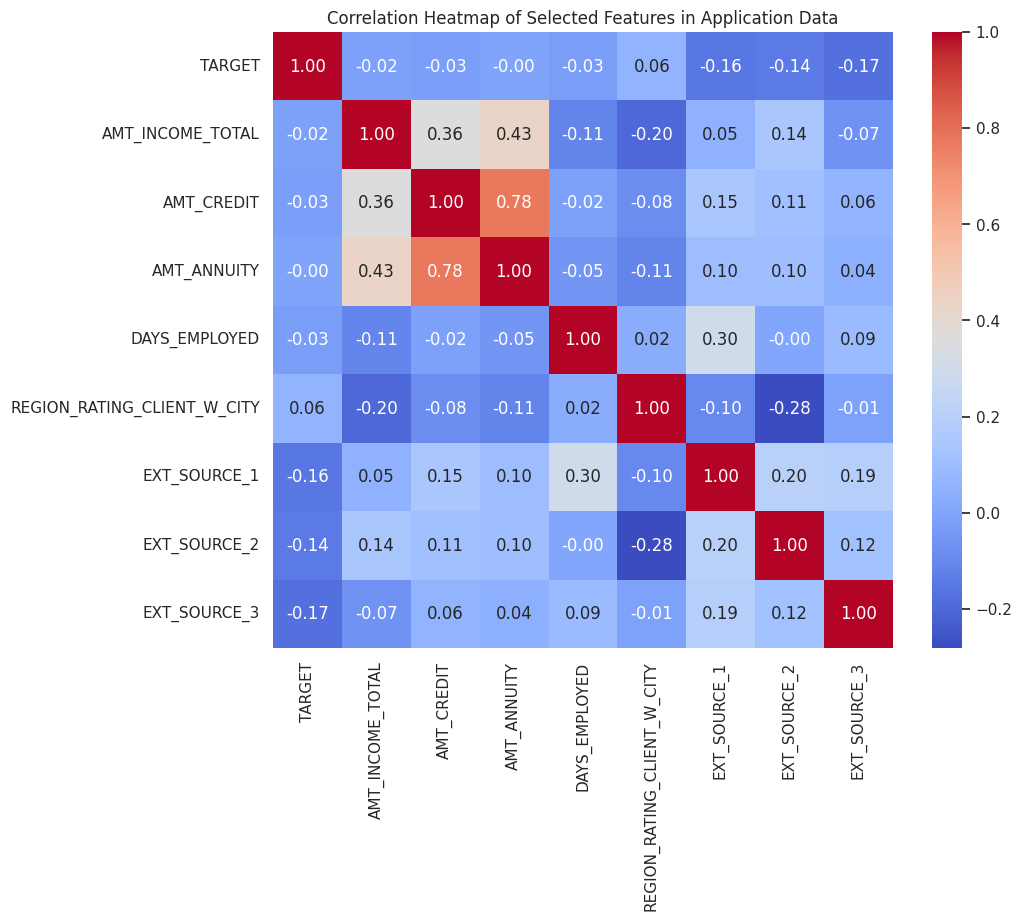

In [52]:
# Selecting a subset of important features to make the heatmap clearer
important_features = [
    'TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'
]

# Subset correlation analysis
subset_data = app_data[important_features].dropna()  # Drop rows with NaN for this analysis
plt.figure(figsize=(10, 8))
corr_subset = subset_data.corr()
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Selected Features in Application Data')
plt.show()

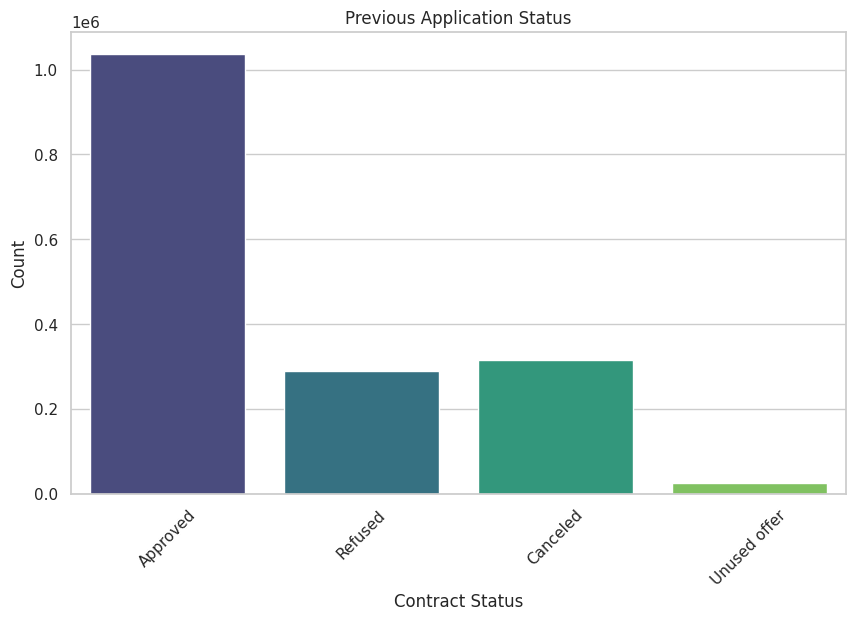

In [53]:
# Comparison of loan status in pre_app
plt.figure(figsize=(10, 6))
sns.countplot(data=pre_app, x='NAME_CONTRACT_STATUS', palette='viridis')
plt.title('Previous Application Status')
plt.xlabel('Contract Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Feature Selection and Engineering

In [54]:
# Step 1: Identify categorical features in app_data
categorical_cols = app_data.select_dtypes(include=['object']).columns

# Step 2: Apply One-Hot Encoding to convert categorical features into numeric
app_data_encoded = pd.get_dummies(app_data, columns=categorical_cols, drop_first=True)

# Step 3: Perform correlation analysis after encoding categorical variables
print("Correlation Analysis After Encoding:")
# Find correlation between features and TARGET
target_corr = app_data_encoded.corr()['TARGET'].sort_values(ascending=False)
print(target_corr)

Correlation Analysis After Encoding:
TARGET                                  1.000000
DAYS_BIRTH                              0.079933
REGION_RATING_CLIENT_W_CITY             0.058915
CODE_GENDER_M                           0.057663
NAME_INCOME_TYPE_Working                0.057128
                                          ...   
NAME_INCOME_TYPE_Pensioner             -0.048524
NAME_EDUCATION_TYPE_Higher education   -0.053374
EXT_SOURCE_1                           -0.155697
EXT_SOURCE_2                           -0.159775
EXT_SOURCE_3                           -0.180330
Name: TARGET, Length: 230, dtype: float64


In [55]:
significant_features = target_corr[abs(target_corr) > 0.05].index
print("\nSignificant features for modeling based on correlation analysis:")
print(significant_features)


Significant features for modeling based on correlation analysis:
Index(['TARGET', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER_M',
       'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY',
       'NAME_EDUCATION_TYPE_Higher education', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3'],
      dtype='object')


In [56]:
# Apply log transformation to features with high skewness
app_data['AMT_INCOME_TOTAL_LOG'] = np.log1p(app_data['AMT_INCOME_TOTAL'])
app_data['AMT_CREDIT_LOG'] = np.log1p(app_data['AMT_CREDIT'])

In [57]:
# Convert `DAYS_BIRTH` to age in years
app_data['AGE_YEARS'] = app_data['DAYS_BIRTH'] / -365

# Convert `DAYS_EMPLOYED` to employment years
app_data['YEARS_EMPLOYED'] = app_data['DAYS_EMPLOYED'] / -365

In [58]:
# Loan to income ratio
app_data['LOAN_INCOME_RATIO'] = app_data['AMT_CREDIT'] / (app_data['AMT_INCOME_TOTAL'] + 1)

In [59]:
# Create bins for age in years
bins = [0, 25, 45, 60, 100]
labels = ['Young', 'Middle-aged', 'Senior', 'Elderly']
app_data['AGE_BIN'] = pd.cut(app_data['AGE_YEARS'], bins=bins, labels=labels)

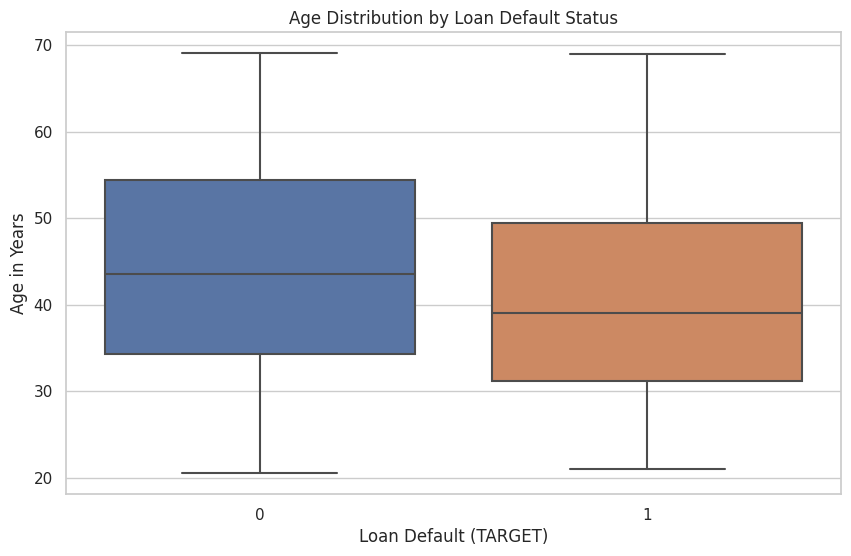

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='TARGET', y='AGE_YEARS', data=app_data)
plt.title('Age Distribution by Loan Default Status')
plt.xlabel('Loan Default (TARGET)')
plt.ylabel('Age in Years')
plt.show()


In [61]:
print(app_data.columns)


Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_INCOME_TOTAL_LOG', 'AMT_CREDIT_LOG', 'AGE_YEARS', 'YEARS_EMPLOYED',
       'LOAN_INCOME_RATIO', 'AGE_BIN'],
      dtype='object', length=128)


In [62]:
poly = PolynomialFeatures(degree=2, include_bias=False)
age_features = app_data[['AGE_YEARS']]
poly_features = poly.fit_transform(age_features)
poly_feature_names = poly.get_feature_names_out(['AGE_YEARS'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
app_data = pd.concat([app_data, poly_df], axis=1)

In [63]:
#  Check for missing values in AGE_YEARS
print("Number of missing values in AGE_YEARS:", app_data['AGE_YEARS'].isnull().sum())

# Drop rows with missing AGE_YEARS
app_data = app_data.dropna(subset=['AGE_YEARS'])

# Reset the index after dropping rows
app_data.reset_index(drop=True, inplace=True)

# Standardize AGE_YEARS
scaler = StandardScaler()
app_data['AGE_YEARS_STANDARDIZED'] = scaler.fit_transform(app_data[['AGE_YEARS']])[:, 0]


Number of missing values in AGE_YEARS: AGE_YEARS    13409
AGE_YEARS    13409
dtype: int64


# Modeling and Model evaluation metrics

Random Forest

In [67]:
# Step 1: Handle Categorical Features - One-Hot Encoding
app_data_encoded = pd.get_dummies(app_data, drop_first=True)

# Step 2: Define Features (X) and Target (y)
X = app_data_encoded.drop(['TARGET'], axis=1)
y = app_data_encoded['TARGET']

# Step 3: Impute Missing Values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Step 4: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Step 5: Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluate the Model Performance
y_pred = model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Test Accuracy: 0.92
Confusion Matrix:
[[51325     0]
 [ 4688     1]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     51325
         1.0       1.00      0.00      0.00      4689

    accuracy                           0.92     56014
   macro avg       0.96      0.50      0.48     56014
weighted avg       0.92      0.92      0.88     56014



Logistic Regression


In [69]:
# Step 1: Handle Categorical Features - One-Hot Encoding
app_data_encoded = pd.get_dummies(app_data, drop_first=True)

# Step 2: Define Features (X) and Target (y)
X = app_data_encoded.drop(['TARGET'], axis=1)
y = app_data_encoded['TARGET']

# Step 3: Impute Missing Values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Step 4: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Step 5: Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train Logistic Regression Model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Step 7: Evaluate the Model Performance
y_pred = logreg.predict(X_test_scaled)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Test Accuracy: 0.92
Confusion Matrix:
[[51261    64]
 [ 4616    73]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     51325
         1.0       0.53      0.02      0.03      4689

    accuracy                           0.92     56014
   macro avg       0.73      0.51      0.49     56014
weighted avg       0.89      0.92      0.88     56014



Gradient Boosting Machine

In [71]:
# Step 1: Handle Categorical Features - One-Hot Encoding
app_data_encoded = pd.get_dummies(app_data, drop_first=True)

# Step 2: Define Features (X) and Target (y)
X = app_data_encoded.drop(['TARGET'], axis=1)
y = app_data_encoded['TARGET']

# Step 3: Impute Missing Values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Step 4: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Step 5: Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train Gradient Boosting Classifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train_scaled, y_train)

# Step 7: Evaluate the Model Performance
y_pred = gbm.predict(X_test_scaled)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Test Accuracy: 0.92
Confusion Matrix:
[[51274    51]
 [ 4622    67]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     51325
         1.0       0.57      0.01      0.03      4689

    accuracy                           0.92     56014
   macro avg       0.74      0.51      0.49     56014
weighted avg       0.89      0.92      0.88     56014



Upsampling

In [78]:
from sklearn.utils import resample

# Separate majority and minority classes
app_data_majority = app_data[app_data.TARGET == 0]
app_data_minority = app_data[app_data.TARGET == 1]

# Upsample minority class
app_data_minority_upsampled = resample(app_data_minority, 
                                       replace=True,           # Sample with replacement
                                       n_samples=len(app_data_majority), # Match number in majority class
                                       random_state=42)        # Reproducible results

# Combine majority class with upsampled minority class
app_data_upsampled = pd.concat([app_data_majority, app_data_minority_upsampled])

# Shuffle the dataset
app_data_upsampled = app_data_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class balance
print(app_data_upsampled['TARGET'].value_counts())


TARGET
1.0    257149
0.0    257149
Name: count, dtype: int64


Upsampling data Results

In [80]:
# Step 1: Handle Categorical Features - One-Hot Encoding (Upsampled Data)
app_data_encoded_upsampled = pd.get_dummies(app_data_upsampled, drop_first=True)

# Step 2: Define Features (X) and Target (y)
X_upsampled = app_data_encoded_upsampled.drop(['TARGET'], axis=1)
y_upsampled = app_data_encoded_upsampled['TARGET']

# Step 3: Impute Missing Values
imputer = SimpleImputer(strategy='median')
X_imputed_upsampled = imputer.fit_transform(X_upsampled)

# Step 4: Split Data into Training and Testing Sets
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_imputed_upsampled, y_upsampled, test_size=0.2, random_state=42)

# Step 5: Train Random Forest Classifier
model_up = RandomForestClassifier(n_estimators=100, random_state=42)
model_up.fit(X_train_up, y_train_up)

# Step 6: Evaluate the Model Performance
y_pred_up = model_up.predict(X_test_up)

# Evaluation Metrics for Upsampled Data
print("\n--- Evaluation Metrics for Upsampled Data ---")
accuracy_up = accuracy_score(y_test_up, y_pred_up)
print(f"Test Accuracy: {accuracy_up:.2f}")

conf_matrix_up = confusion_matrix(y_test_up, y_pred_up)
print("Confusion Matrix:")
print(conf_matrix_up)

class_report_up = classification_report(y_test_up, y_pred_up)
print("Classification Report:")
print(class_report_up)



--- Evaluation Metrics for Upsampled Data ---
Test Accuracy: 1.00
Confusion Matrix:
[[51420   186]
 [    5 51249]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     51606
         1.0       1.00      1.00      1.00     51254

    accuracy                           1.00    102860
   macro avg       1.00      1.00      1.00    102860
weighted avg       1.00      1.00      1.00    102860



Regularizing Upsampled data


In [81]:
# Step 1: Handle Categorical Features - One-Hot Encoding (Upsampled Data)
app_data_encoded_upsampled = pd.get_dummies(app_data_upsampled, drop_first=True)

# Step 2: Define Features (X) and Target (y)
X_upsampled = app_data_encoded_upsampled.drop(['TARGET'], axis=1)
y_upsampled = app_data_encoded_upsampled['TARGET']

# Step 3: Impute Missing Values
imputer = SimpleImputer(strategy='median')
X_imputed_upsampled = imputer.fit_transform(X_upsampled)

# Step 4: Split Data into Training and Testing Sets
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_imputed_upsampled, y_upsampled, test_size=0.2, random_state=42)

# Step 5: Train Regularized Random Forest Classifier on Upsampled Data
model_up_regularized = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=10,               # Limiting the depth of each tree to prevent overfitting
    min_samples_split=10,       # Increasing the minimum samples required to split a node
    min_samples_leaf=5,         # Increasing the minimum number of samples in leaf nodes
    random_state=42             # For reproducibility
)
model_up_regularized.fit(X_train_up, y_train_up)

# Step 6: Evaluate the Regularized Model Performance (Upsampled Data)
y_pred_up_regularized = model_up_regularized.predict(X_test_up)

# Evaluation Metrics for Regularized Random Forest (Upsampled Data)
print("\n--- Evaluation Metrics for Regularized Random Forest on Upsampled Data ---")
accuracy_up_regularized = accuracy_score(y_test_up, y_pred_up_regularized)
print(f"Test Accuracy: {accuracy_up_regularized:.2f}")

conf_matrix_up_regularized = confusion_matrix(y_test_up, y_pred_up_regularized)
print("Confusion Matrix:")
print(conf_matrix_up_regularized)

class_report_up_regularized = classification_report(y_test_up, y_pred_up_regularized)
print("Classification Report:")
print(class_report_up_regularized)


--- Evaluation Metrics for Regularized Random Forest on Upsampled Data ---
Test Accuracy: 0.72
Confusion Matrix:
[[36330 15276]
 [13659 37595]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.70      0.72     51606
         1.0       0.71      0.73      0.72     51254

    accuracy                           0.72    102860
   macro avg       0.72      0.72      0.72    102860
weighted avg       0.72      0.72      0.72    102860

